# __Movie Sentiment Analysis__

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from collections import Counter


warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [2]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [5]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [6]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 
               'poster_path', 'budget', 'revenue', 'adult', 'overview', 'tagline', 'production_countries', 'runtime', 
               'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,genres,imdb_id,production_companies,release_date,title,cast,crew
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [7]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [8]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [9]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [10]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,genres,imdb_id,production_companies,release_date,title,cast,crew,movie,genre
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [11]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw1133942,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8.0,Good follow up that answers all the questions,24 July 2005,0,"After seeing Tarantino's Kill Bill Vol: 1, I g...","['0', '1']"
1,rw1133959,lost-in-limbo,Feardotcom (2002),3.0,"""I couldn't make much sense of it myself"". Too...",24 July 2005,0,There's a Website called FearDotCom and anyone...,"['1', '4']"
2,rw1133985,NateManD,Persona (1966),10.0,Persona gives me all the reasons to love art-h...,24 July 2005,0,"Long before ""Muholland Drive"" there was anothe...","['9', '23']"
3,rw1133999,CAMACHO-4,War of the Worlds (2005),3.0,A disappointing film from the team that you Mi...,24 July 2005,0,Spielberg said this film is based on the H.G. ...,"['9', '14']"
4,rw1134010,CAMACHO-4,Mr. & Mrs. Smith (2005),6.0,A fun action movie with great chemistry,24 July 2005,0,"Director Doug Liman, who's gotten famous for m...","['1', '3']"


In [12]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1166979,dee.reid,10.0,"""Toy Story"" - The Toys are in town and somethi...",6 September 2005,0,"I'm 19, going on 20 in six days. I don't need ...","['5', '5']"
1,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1184497,emasterslake,NaN,Pixar's first full length movie.,1 October 2005,0,This was the first Pixar movie I've seen. I re...,"['0', '0']"
2,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1202306,patrick_dunne,10.0,Classic Pixar! This is what future Pixar films...,26 October 2005,0,Remember the original Pixar movies? Remember w...,"['0', '0']"
3,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1213162,Lady_Targaryen,8.0,One of the first animations from Pixar,10 November 2005,0,"When Toy Story came, in 1995,I was 9 years old...","['27', '43']"
4,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1223346,KUAlum26,10.0,Can it be ten years already?,23 November 2005,0,PIXAR animation was but an experimental animat...,"['1', '1']"


In [13]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful', 'rating']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,review_summary,review_date,review_detail
0,114709,"""Toy Story"" - The Toys are in town and somethi...",6 September 2005,"I'm 19, going on 20 in six days. I don't need ..."
1,114709,Pixar's first full length movie.,1 October 2005,This was the first Pixar movie I've seen. I re...
2,114709,Classic Pixar! This is what future Pixar films...,26 October 2005,Remember the original Pixar movies? Remember w...
3,114709,One of the first animations from Pixar,10 November 2005,"When Toy Story came, in 1995,I was 9 years old..."
4,114709,Can it be ten years already?,23 November 2005,PIXAR animation was but an experimental animat...


## Exploratory Data Analysis

Check and resolve duplicate records

In [14]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [15]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 557581
Record count after removing duplicates  => 542633


Check and resolve missing values for `movie metadata`

In [16]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

genres                  3
imdb_id                 0
production_companies    3
release_date            3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [17]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,genres,imdb_id,production_companies,release_date,title,cast,crew,movie,genre
2780,NaN,462322,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,448694,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,1937390,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [18]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   genres                4068 non-null   object
 1   imdb_id               4068 non-null   int64 
 2   production_companies  4068 non-null   object
 3   release_date          4068 non-null   object
 4   title                 4068 non-null   object
 5   cast                  4068 non-null   object
 6   crew                  4068 non-null   object
 7   movie                 4068 non-null   object
 8   genre                 4068 non-null   object
dtypes: int64(1), object(8)
memory usage: 317.8+ KB


Check and resolve missing values for `movie reviews`

In [19]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id           0
review_summary    1
review_date       0
review_detail     1
dtype: int64

In [20]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542633 entries, 0 to 557580
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   imdb_id         542633 non-null  int64 
 1   review_summary  542633 non-null  object
 2   review_date     542633 non-null  object
 3   review_detail   542633 non-null  object
dtypes: int64(1), object(3)
memory usage: 20.7+ MB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [21]:
# Separate movie release year from the title. Get only the year the review was created
movies_metadata_df['release_year'] = pd.to_datetime(movies_metadata_df['release_date']).dt.year

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'movie']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'title', 'release_year', 'genre', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,title,release_year,genre,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [22]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies']\
                                                .apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies']\
                                                .apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [23]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)
movie_reviews_df.head(5)

,imdb_id,review_summary,review_detail,review_year
0,114709,"""Toy Story"" - The Toys are in town and somethi...","I'm 19, going on 20 in six days. I don't need ...",2005
1,114709,Pixar's first full length movie.,This was the first Pixar movie I've seen. I re...,2005
2,114709,Classic Pixar! This is what future Pixar films...,Remember the original Pixar movies? Remember w...,2005
3,114709,One of the first animations from Pixar,"When Toy Story came, in 1995,I was 9 years old...",2005
4,114709,Can it be ten years already?,PIXAR animation was but an experimental animat...,2005


Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [24]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,review_year
count,5.425070e+05,542507.000000,542507.000000
mean,5.652373e+05,1995.824507,2010.015587
std,7.657242e+05,18.346792,6.248968
min,4.170000e+02,1902.000000,1998.000000
25%,9.607100e+04,1988.000000,2005.000000
50%,2.571060e+05,2002.000000,2010.000000
75%,7.654290e+05,2008.000000,2015.000000
max,5.247022e+06,2017.000000,2021.000000


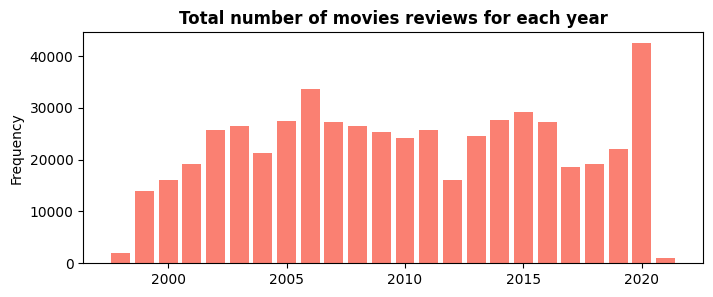

In [25]:
# Show the total number of movie reviews for each year
review_year_counts = Counter(movie_reviews_df['review_year'])
year, counts = zip(*review_year_counts.items())

plt.figure(figsize=(8, 3))
plt.bar(year, counts, color='salmon')
plt.ylabel('Frequency')
plt.title('Total number of movies reviews for each year', weight='bold')
plt.show()

Total number of movies => 4070


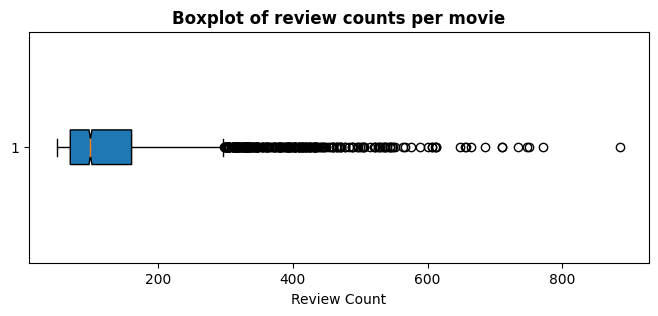

In [26]:
# Retrieve the count of reviews for each movie. Utilize a boxplot to visualize the distribution.
grouped_movie_count = movie_reviews_df.groupby('imdb_id').size().reset_index(name='review_count')\
                        .sort_values(by='review_count', ascending=False)

print(f"Total number of movies => {len(grouped_movie_count.index)}")

plt.figure(figsize=(8, 3))
plt.boxplot(grouped_movie_count['review_count'], vert=False, notch=True, patch_artist=True)
plt.title('Boxplot of review counts per movie', weight='bold')
plt.xlabel('Review Count')
plt.show()

In [27]:
# To enhance the model's effectiveness, we will narrow down the dataset to include only movies that have received a minimum of 100 reviews

grouped_movie_gt100_reviews_df = grouped_movie_count[grouped_movie_count['review_count'] >= 100]
print(f"Total number of movies with at least 100 reviews => {len(grouped_movie_gt100_reviews_df.index)}")
print("--------------------------------------------------------------------------------------------")

print(f"Total number of movie reviews (before removing movies with less than 100 reviews) => {len(movie_reviews_df.index)}")

# Drop  all reviews associated with movies that have received fewer than 100 reviews, 
# assuming that these movies are relatively less favored by viewers
movies_metadata_df = movies_metadata_df.merge(grouped_movie_gt100_reviews_df, on='imdb_id', how='inner')
movie_reviews_df = movie_reviews_df.merge(grouped_movie_gt100_reviews_df, on='imdb_id', how='inner')
movie_reviews_df = movie_reviews_df.drop(columns=['review_count'], axis=1)

print(f"Total number of movie reviews (after removing movies with less than 100 reviews)  => {len(movie_reviews_df.index)}")

Total number of movies with at least 100 reviews => 2065
--------------------------------------------------------------------------------------------
Total number of movie reviews (before removing movies with less than 100 reviews) => 542633
Total number of movie reviews (after removing movies with less than 100 reviews)  => 399393


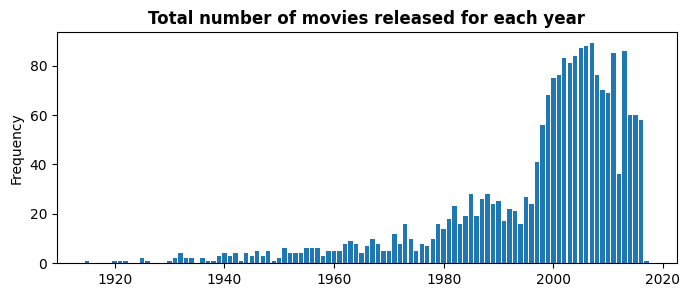

In [28]:
# Show the total number of movie released for each year
release_year_counts = Counter(movies_metadata_df.merge(grouped_movie_count, on='imdb_id', how='inner')['release_year'])
release_year, release_counts = zip(*release_year_counts.items())

plt.figure(figsize=(8, 3))
plt.bar(release_year, release_counts)
plt.ylabel('Frequency')
plt.title('Total number of movies released for each year', weight='bold')
plt.show()

In [29]:
# Considering popular streaming platforms like Netflix, Disney+, and Amazon Prime, we find that the earliest films available 
# date back to the mid-1920s or late 1930s. Therefore, we get the average and exclude movies released prior to 1930s.

print(f"Total number of movie reviews (before removing movies prior to 1930s) => {len(movies_metadata_df.index)}")
movies_metadata_df = movies_metadata_df[movies_metadata_df['release_year'] >= 1930]
print(f"Total number of movie reviews (after removing movies prior to 1930s) => {len(movies_metadata_df.index)}")

Total number of movie reviews (before removing movies prior to 1930s) => 2066
Total number of movie reviews (after removing movies prior to 1930s) => 2059


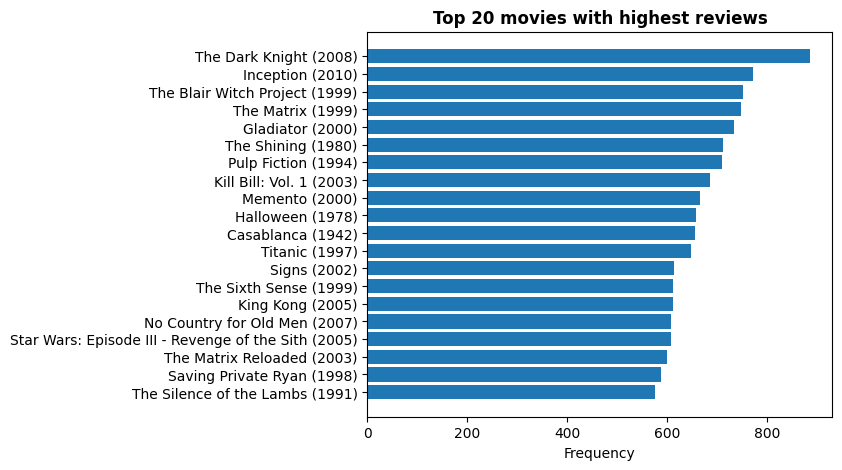

In [30]:
# Show the top 20 movies with highest reviews
movie_count_temp_df = movies_metadata_df[['title', 'release_year', 'review_count']]\
                        .sort_values(by='review_count', ascending=False).head(20)

movie_year = movie_count_temp_df['title'] + " (" + movie_count_temp_df['release_year'].astype(str) + ")"
review_count = movie_count_temp_df['review_count']

plt.figure(figsize=(6, 5))
plt.barh(movie_year[::-1], review_count[::-1])
plt.xlabel('Frequency')
plt.title('Top 20 movies with highest reviews', weight='bold')
plt.show()

In [31]:
# TODO: Visualizations for genres, production companies, cast and crews

#### __For Text Pre-processing__:

__The movie summary and reviews undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [32]:
emoji_dict = tp.get_emojis()
slang_word_dict = tp.get_slang_words(webscraped=False)

def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)

        # Replace non-ascii characters as there are Python libraries limiting to ascii
        text = tp.replace_nonascii_characters(text)

        # Replace emojis with English word/s
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(initial_text_preprocessing)
movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']].head(5)

,cleaned_review_summary,cleaned_review_detail
0,"""Toy Story"" - The Toys are in town and somethi...","I am 19, going on 20 in six days. I do not nee..."
1,Pixar's first full length movie.,This was the first Pixar movie I have seen. I ...
2,Classic Pixar! This is what future Pixar films...,Remember the original Pixar movies? Remember w...
3,One of the first animations from Pixar,"When Toy Story came, in 1995,I was 9 years old..."
4,Can it be ten years already?,PIXAR animation was but an experimental animat...


__Apply regular expressions to remove punctuation and spaces, and convert characters to lowercase.__

In [35]:
# Function to clean text by removing non-alphanumeric, converting to lowercase, and stripping whitespaces
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters except for the following
    # > hyphen (-) that is in between alphanumeric
    text = tp.remove_non_alphanumeric_char(text)
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Replace multiple whitespaces with a single space
    text = tp.replace_whitespace(text)

    return text

# Apply text cleaning to 'review_summary' and 'review_detail' columns
movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']]\
                                                                            .applymap(clean_text)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
"Toy Story" - The Toys are in town and something more

Cleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):
toy story the toys are in town and something more
Original Review Summary:
Pixar's first full length movie.

Cleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):
pixar s first full length movie
Original Review Summary:
Classic Pixar! This is what future Pixar films should be like!

Cleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):
classic pixar this is what future pixar films should be like
Original Review Summary:
One of the first animations from Pixar

Cleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased, Extra Whitespaces Removed):
one of the first animations from pixar
Original Review Summary:
Can it be ten years already?

Cleaned Review Summary (Non-alphanumeric charactes Removed, Lowercased

__Remove stopwords then apply spacy lemmatization on movie reviews__

In [37]:
# TODO: Words with hyphen are being tokenized or split

# Apply stop word removal to 'review_summary' and 'review_detail' columns
movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']]\
                                                                            .applymap(tp.remove_stopwords)
# Apply lemmatization to 'review_summary' and 'review_detail' columns
movie_reviews_df['cleaned_review_summary'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_summary'])
movie_reviews_df['cleaned_review_detail'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_detail'])

# Display the comparison between the top 5 original review summaries and their lemmatized versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nLemmatized Review Summary:")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their lemmatized versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nLemmatized Review Details:")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

## Model Creation

## Model Evaluation

## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/
- https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#google_vignette
- https://atilaycemsamiloglu.medium.com/what-is-lemmatization-2d7a87f42c55
- https://support.prodi.gy/t/how-to-tell-spacy-not-to-split-any-intra-hyphen-words/1456
- https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8